In [ ]:

%matplotlib inline
import tensorflow as tf 
import numpy as np
import glob
from PIL import Image
import skimage.io
import skimage.segmentation
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from __future__ import print_function 



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [ ]:
# We're unzipping the cuDNN files from your Drive folder directly to the VM CUDA folders
!tar -xzvf "/content/gdrive/My Drive/darknet/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz" -C "/usr/local/"
!chmod a+r /usr/local/cuda/include/cudnn.h

# Now we check the version we already installed. Can comment this line on future runs
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


In [ ]:
# Leave this code uncommented on the very first run of your notebook or if you ever need to recompile darknet again.
# Comment this code on the future runs.
!git clone https://github.com/kriyeng/darknet/
%cd /content/darknet


Cloning into 'darknet'...
remote: Enumerating objects: 10068, done.
remote: Total 10068 (delta 0), reused 0 (delta 0), pack-reused 10068
Receiving objects: 100% (10068/10068), 10.04 MiB | 6.71 MiB/s, done.
Resolving deltas: 100% (6740/6740), done.
/content/darknet


In [ ]:
# Check the folder
!ls

# I have a branch where I have done the changes commented above
!git checkout feature/google-colab

#Compile Darknet
!make


3rdparty      CMakeLists.txt	      image_yolov3.sh	     scripts
appveyor.yml  CMakeSettings.json      include		     src
build	      DarknetConfig.cmake.in  json_mjpeg_streams.sh  video_v2.sh
build.ps1     darknet.py	      LICENSE		     video_yolov3.sh
build.sh      darknet_video.py	      Makefile
cfg	      data		      net_cam_v3.sh
cmake	      image_yolov2.sh	      README.md
Branch 'feature/google-colab' set up to track remote branch 'feature/google-colab' from 'origin'.
Switched to a new branch 'feature/google-colab'
mkdir -p obj
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(mat_cv*, detection*, int, float, char**, image**, in

In [ ]:
#Copies the Darknet compiled version to Google drive
!cp ./darknet "/content/gdrive/My Drive/darknet/bin/darknet"

In [ ]:
!ls "/content/gdrive/My Drive/darknet/bin/darknet/"

darknet


In [ ]:
# Uncomment after the first run, when you have a copy of compiled darkent in your Google Drive

# Makes a dir for darknet and move there
#!mkdir darknet
#%cd darknet


# Copy the Darkent compiled version to the VM local drive
#!cp -r "/content/gdrive/My Drive/darknet/bin/darknet" ./darknet

#Set execution permissions to Darknet
#!chmod +x ./darknet



In [ ]:
#Set execution permissions to Darknet
#!chmod +x ./darknet/
%cd /content/darknet/

/content/darknet


In [ ]:
#!/content/darknet/darknet/darknet

In [ ]:
#download files
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
def download(path):
  from google.colab import files
  files.download(path)

In [ ]:
# Not necessary cell
# Get yolov3 weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2019-05-29 20:17:36--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  30.2MB/s    in 8.4s    

2019-05-29 20:17:45 (28.2 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
%cd /content/darknet/cfg/
!rm /content/darknet/cfg/yolov3.cfg
!cp /content/gdrive/My\ Drive/darknet/cfg/yolov3.cfg /content/darknet/cfg/

%cd /content/darknet/
!cp /content/gdrive/My\ Drive/darknet/backup/yolov3_last.weights /content/darknet/
!rm yolov3.weights
!mv yolov3_last.weights yolov3.weights
!rm /content/darknet/data/coco.names  
!cp /content/gdrive/My\ Drive/darknet/coco.names /content/darknet/data/coco.names 
!rm /content/darknet/cfg/coco.data
!cp /content/gdrive/My\ Drive/darknet/coco.data /content/darknet/cfg/

/content/darknet/cfg
/content/darknet


layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF
   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF
   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF
   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF
   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF
  13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  76 x 128 0.379 BF
  14 c

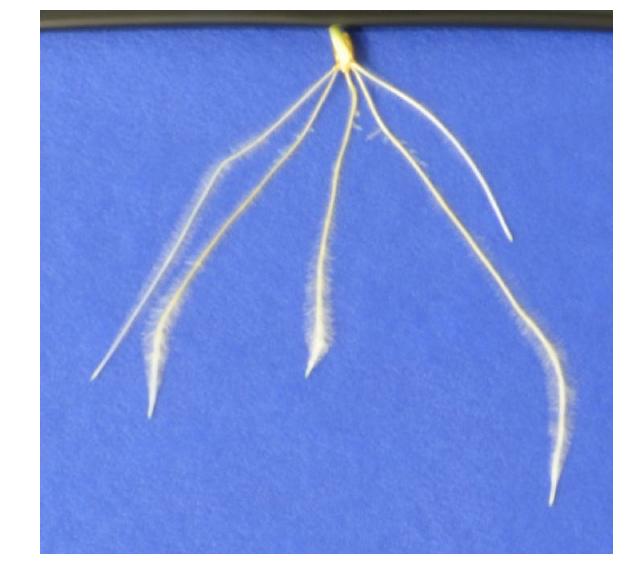

In [ ]:
# Not necessary cell
# Execute darknet using YOLOv3 model with pre-trained weights to detect objects on 'person.jpg'
! ./darknet detect cfg/yolov3.cfg yolov3.weights /content/gdrive/My\ Drive/darknet/img/0000.png -dont-show

# Show the result using the helper imgShow()
imShow('predictions.jpg')

In [ ]:
#!rm /content/darknet/data/coco.names
#!rm /content/darknet/cfg/coco.data 
#!rm /content/darknet/cfg/yolov3.cfg

#!cp /content/gdrive/My\ Drive/darknet/coco.names /content/darknet/data/
#!cp /content/gdrive/My\ Drive/darknet/coco.names /content/darknet/cfg/
#!cp /content/gdrive/My\ Drive/darknet/coco.data /content/darknet/cfg/
#!cp /content/gdrive/My\ Drive/darknet/cfg/yolov3.cfg /content/darknet/cfg/yolov3.cfg 

In [ ]:
#%cd /content/gdrive/My Drive/darknet/img
#!ls -1 /content/gdrive/My\ Drive/darknet/img/{0000..2156}.png > "/content/gdrive/My Drive/darknet/train2.txt"

In [ ]:
%cd /content/darknet/cfg/
!rm /content/darknet/cfg/yolov3.cfg
!cp /content/gdrive/My\ Drive/darknet/cfg/yolov3.cfg /content/darknet/cfg/

%cd /content/darknet/

/content/darknet/cfg
/content/darknet


In [ ]:
%cd /content/darknet
!./darknet detector train "/content/darknet/cfg/coco.data" "/content/gdrive/My Drive/darknet/cfg/yolov3.cfg" "/content/gdrive/My Drive/darknet/weights/darknet53.conv.74" -dont_show 

/content/darknet
yolov3
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32 0.639 BF
   1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64 3.407 BF
   2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32 0.379 BF
   3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128 3.407 BF
   6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
   7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64 0.379 BF
  10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128 3.407 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   152 x 152 x 128   ->    76 x  76 x 256 3.407 BF
  13 conv    128  1 x 1 / 1    76 x  76 x 256   ->    76 x  

In [ ]:
# Start training at the point where the last runtime finished
#!./darknet detector train "/content/gdrive/My Drive/darknet/coco.data" "/content/gdrive/My Drive/darknet/yolov3.cfg" "/content/gdrive/My Drive/darknet/weights/yolov_last.weights" -dont_show 

In [ ]:
#cp -r * 
#rm -rf *.